<a href="https://colab.research.google.com/github/Yanina-Kutovaya/portfolio/blob/master/Transformer_keras%2BTime2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Playground Series - Jan 2022

https://www.kaggle.com/c/tabular-playground-series-jan-2022

In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import scipy.stats as st

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

### 1. Upload data from Kaggle

In [ ]:
!pip install -q kaggle 

In [ ]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kutovaiayp","key":"8b3b3eb09b29d35b31a0a2ca55acc23c"}'}

In [ ]:
#!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                      2022 Ukraine Russia War                            2KB  2022-04-13 07:24:12           7779        435  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease  Personal Key Indicators of Heart Disease           3MB  2022-02-16 10:18:03          12720        275  1.0              
datasets/ankanhore545/cost-of-living-index-2022                Cost of Living Index 2022                          4KB  2022-04-09 06:22:10           2587         47  0.8235294        
datasets/prasertk/best-tv-shows-of-all-time                    Best TV shows of 

In [ ]:
!kaggle competitions download -c tabular-playground-series-jan-2022

  0% 0.00/230k [00:00<?, ?B/s]
100% 230k/230k [00:00<00:00, 38.1MB/s]


In [ ]:
!unzip tabular-playground-series-jan-2022.zip -d '/content/input'

Archive:  tabular-playground-series-jan-2022.zip
  inflating: /content/input/sample_submission.csv  
  inflating: /content/input/test.csv  
  inflating: /content/input/train.csv  


### 2. Reading data

In [ ]:
train = pd.read_csv('/content/input/train.csv', index_col=0)
test = pd.read_csv('/content/input/test.csv', index_col=0)

data = pd.concat([train, test])
data.head(2)

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0


In [ ]:
data['date'] = pd.to_datetime(data['date'])
table = pd.pivot_table(data, columns=['date'], index=['country', 'store', 'product'], aggfunc=np.sum)                      
ind = table.index.tolist()
table.reset_index(inplace=True)
table.head()

country       store         product   num_sold                        \
date      NaT         NaT             NaT 2015-01-01 2015-01-02 2015-01-03   
0     Finland  KaggleMart      Kaggle Hat      520.0      493.0      535.0   
1     Finland  KaggleMart      Kaggle Mug      329.0      318.0      360.0   
2     Finland  KaggleMart  Kaggle Sticker      146.0      127.0      141.0   
3     Finland  KaggleRama      Kaggle Hat      911.0      794.0      843.0   
4     Finland  KaggleRama      Kaggle Mug      572.0      544.0      579.0   

                                                  ...                        \
date 2015-01-04 2015-01-05 2015-01-06 2015-01-07  ... 2019-12-22 2019-12-23   
0         544.0      378.0      389.0      342.0  ...        0.0        0.0   
1         332.0      243.0      223.0      229.0  ...        0.0        0.0   
2         125.0      102.0       99.0       91.0  ...        0.0        0.0   
3         873.0      668.0      636.0      576.0  ...        0.0        0.0   
4         582.0      423.0      407.0      356.0  ...        0.0        0.0   

                                                                        \
date 2019-12-24 2019-12-25 2019-12-26 2019-12-27 2019-12-28 2019-12-29   
0           0.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        0.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        0.0        0.0   

                            
date 2019-12-30 2019-12-31  
0           0.0        0.0  
1           0.0        0.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0  

[5 rows x 1829 columns]

In [ ]:
n_products = table.shape[0]
print(f'The number of products to forecast = {n_products}')

n_train = data['date'][:len(train)].nunique()
n_test = data['date'][len(train):].nunique()

print(f'number of train days = {n_train}')
print(f'number of test days = {n_test}')

The number of products to forecast = 18
number of train days = 1461
number of test days = 365


In [ ]:
SEQ_OUT = 365
SEQ_IN = 2 * SEQ_OUT
WINDOW = SEQ_IN + SEQ_OUT

print(f'input sequence length = {SEQ_IN}')
print(f'output sequence length = {SEQ_OUT}')
print(f'window length = {WINDOW}')

input sequence length = 730
output sequence length = 365
window length = 1095


In [ ]:
category_features=['country', 'store', 'product']

### 3. EDA

#### 3.1 Omissions check

In [ ]:
time_stamp = table['num_sold'].columns
all_calendar_days = pd.date_range(start=time_stamp[0], end=time_stamp[-1])
missing_days = [i for i in all_calendar_days if i not in time_stamp]
missing_days

[]

__Conclusion__: There is no omissions in data

#### 3.2 Descriptive statistics

In [ ]:
df = table['num_sold'].iloc[:, :n_train].transpose()
df.index = time_stamp[:n_train]
round(df.describe(), 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0,1461.0
mean,362.5,204.2,103.0,628.9,356.1,180.2,594.6,334.4,169.6,1036.4,584.3,295.6,419.2,235.9,119.6,731.5,411.3,208.3
std,97.5,54.4,21.7,165.6,94.9,38.7,158.4,82.3,34.3,276.8,142.5,59.5,109.3,59.2,24.3,189.3,104.6,42.2
min,210.0,126.0,70.0,354.0,220.0,128.0,335.0,201.0,114.0,596.0,366.0,214.0,248.0,149.0,86.0,428.0,253.0,148.0
25%,292.0,173.0,89.0,515.0,301.0,155.0,482.0,284.0,147.0,841.0,500.0,256.0,337.0,201.0,105.0,591.0,351.0,183.0
50%,350.0,195.0,100.0,608.0,340.0,174.0,571.0,319.0,162.0,990.0,558.0,285.0,408.0,225.0,114.0,714.0,394.0,198.0
75%,410.0,224.0,111.0,712.0,392.0,195.0,673.0,367.0,182.0,1163.0,639.0,319.0,475.0,253.0,129.0,826.0,445.0,226.0
max,1113.0,774.0,326.0,1895.0,1398.0,559.0,1809.0,1113.0,518.0,2884.0,1935.0,874.0,1207.0,730.0,356.0,2169.0,1438.0,637.0


__Box plot__

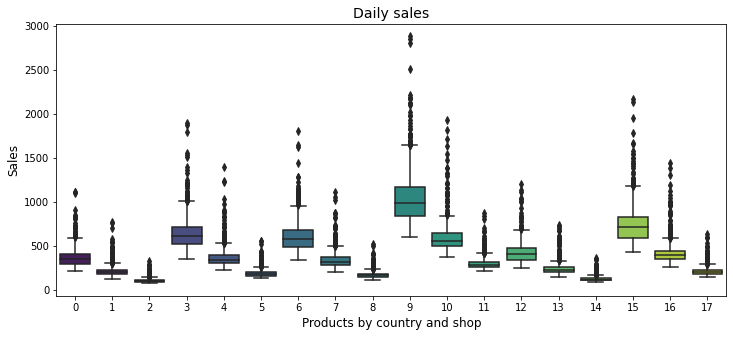

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Daily sales', size=14)
plt.xlabel('Products by country and shop', size=12)
plt.ylabel('Sales', size=12)
sns.boxplot(data=df, palette="viridis");

__Distribution analysis__

In [ ]:
def get_distribution(data, product):
  target = data[product]
  fig, axes = plt.subplots(1, 3, figsize=(12, 3))

  axes[0].set_title("Johnson SU", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

  axes[1].set_title("Normal", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

  axes[2].set_title("Log Normal", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])
  plt.show()

Product 0


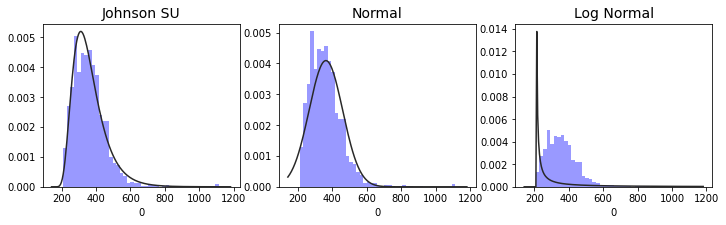

Product 1


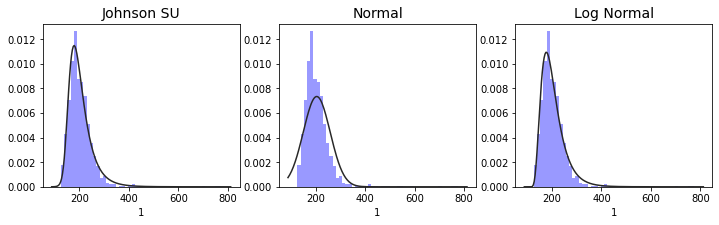

Product 2


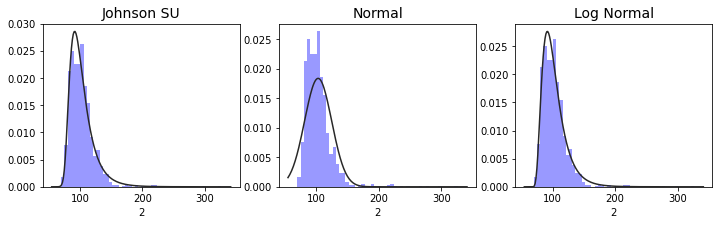

Product 3


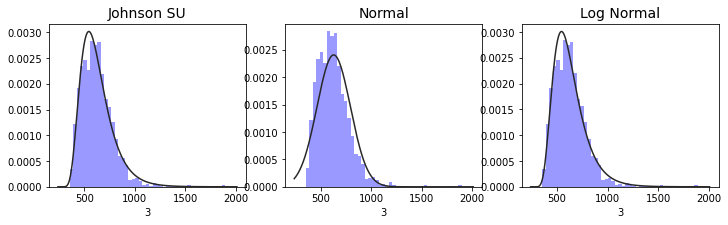

Product 4


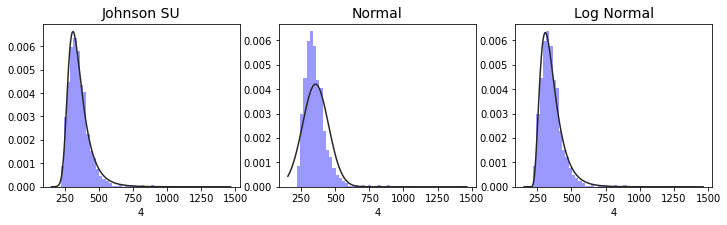

Product 5


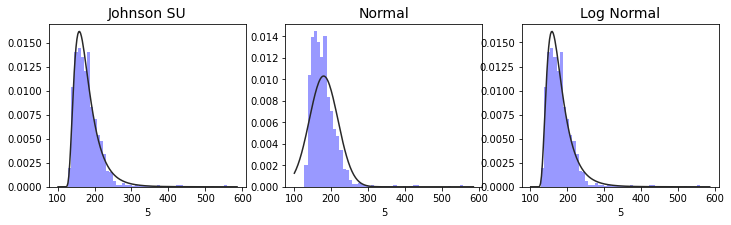

Product 6


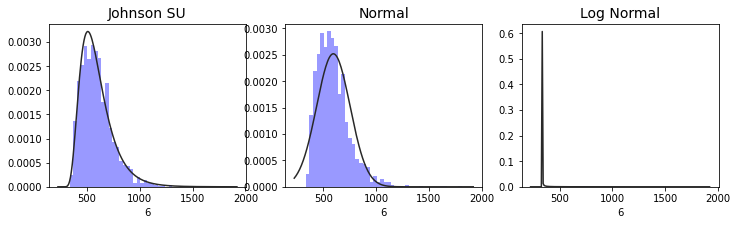

Product 7


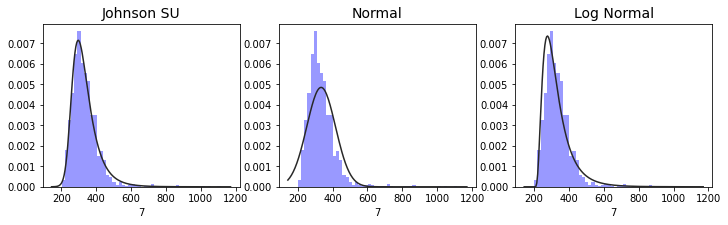

Product 8


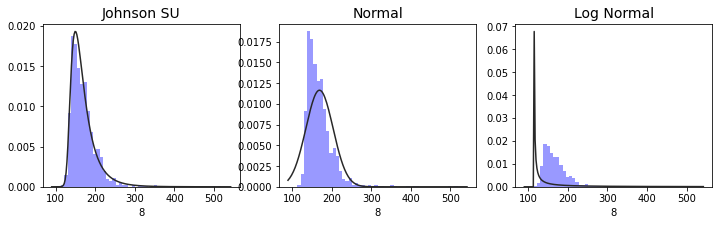

Product 9


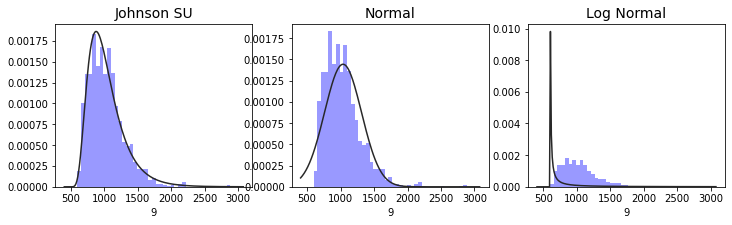

Product 10


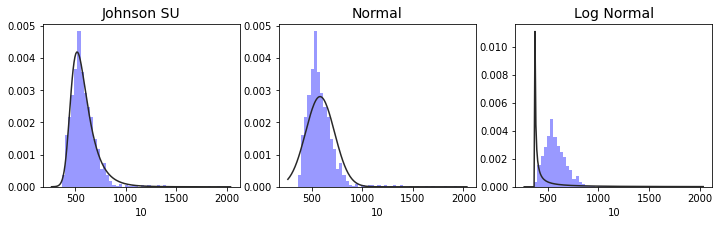

Product 11


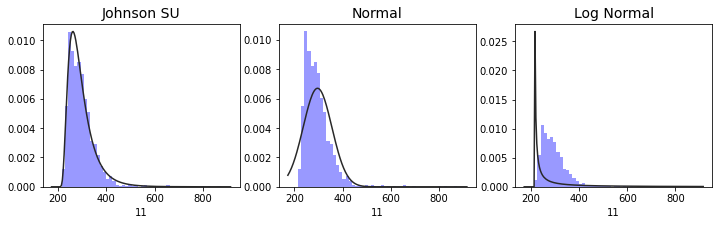

Product 12


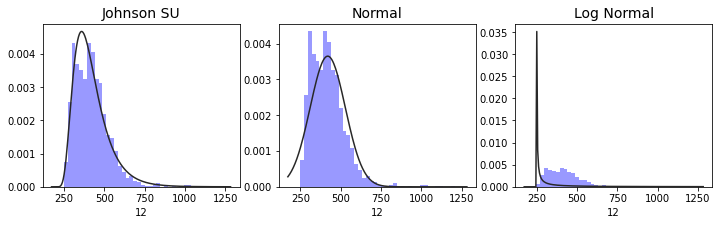

Product 13


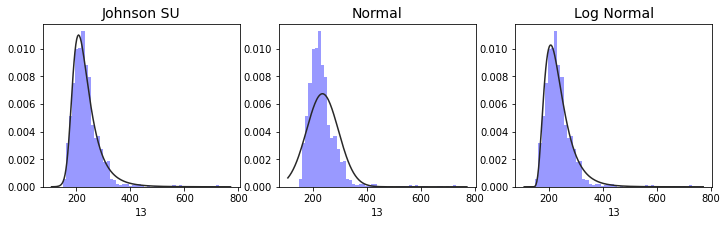

Product 14


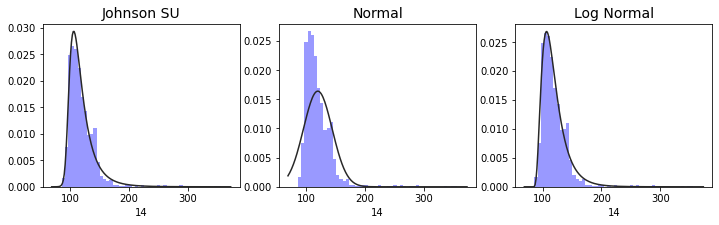

Product 15


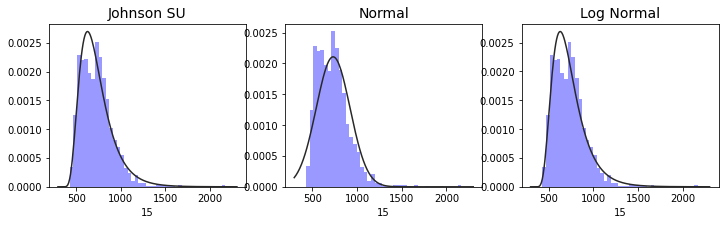

Product 16


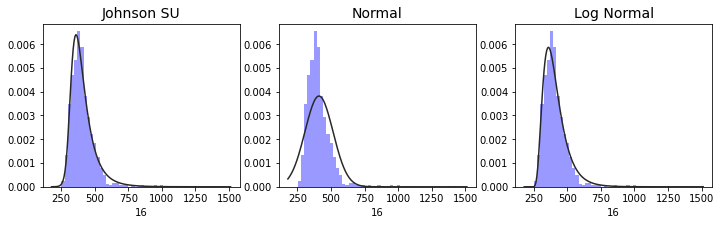

Product 17


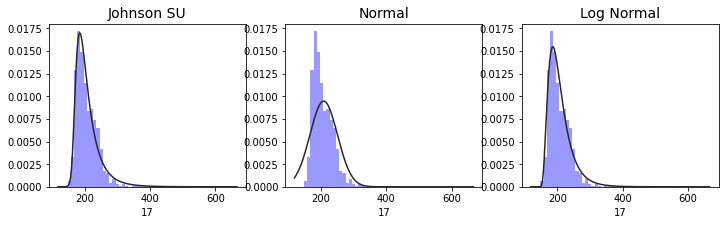

In [ ]:
for product in range(n_products):
  print(f'Product {product}')
  get_distribution(df, product)

__Conclusion:__
It is obvious that target variable is not normally distributed. The closest approximation is Johnson SU distribution.

#### 3.3 JohnsonSU transformation

In [ ]:
class JohnsonSU():
  """
    Johnson SU transformation according to
    https://en.wikipedia.org/wiki/Johnson%27s_SU-distribution
  """
  def __init__(self):    
    self.johnsonsu_params = dict()   

    
  def fit(self, X):        
    for i in range(n_products):      
      self.johnsonsu_params[i] = st.johnsonsu.fit(X[i])
      

  def transform(self, X):
    def johnsonsu_transform(x):
        return a + b * tf.math.asinh((x - loc) / scale)

    X_transformed = []
    for i in range(n_products): 
      a, b, loc, scale = self.johnsonsu_params[i]      
      X_transformed.append(tf.map_fn(johnsonsu_transform, X[i]))

    return tf.transpose(tf.stack(X_transformed))


  def inv_transform(self, X):
    def johnsonsu_inv_transform(x):
      return loc + scale * tf.math.sinh((x - a) / b) 

    X_transformed = []    
    for i in range(n_products): 
      a, b, loc, scale = self.johnsonsu_params[i]
      X_transformed.append(tf.map_fn(johnsonsu_inv_transform, X[:, i]))

    return tf.stack(X_transformed, axis=-1)

In [ ]:
scaler = JohnsonSU()
scaler.fit(df)
df_transformed = scaler.transform(df)

df.loc[:, :] = df_transformed.numpy()

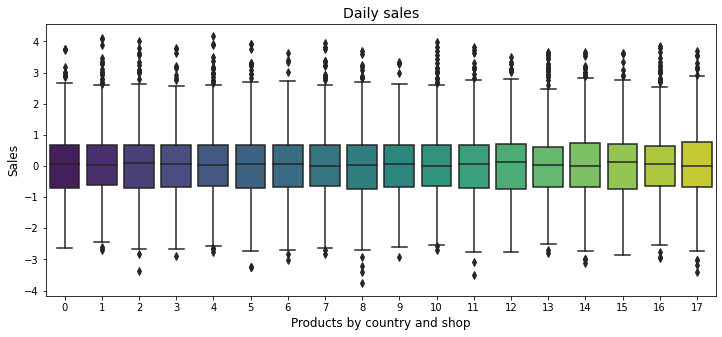

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Daily sales', size=14)
plt.xlabel('Products by country and shop', size=12)
plt.ylabel('Sales', size=12)
sns.boxplot(data=df, palette="viridis");

#### 3.4 Median daily sales by the year

In [ ]:
year_medians = pd.pivot_table(
    df, index=df.index.year, aggfunc=np.median)

year_medians

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
date,,,,,,,,,,,,,,,,,,
2015,-0.331519,-0.454706,-0.807882,-0.234608,-0.454609,-0.759069,-0.126100,-0.206067,-0.386956,-0.085038,-0.207064,-0.465582,-0.130313,-0.262546,-0.585979,-0.121311,-0.277258,-0.564648
2016,-0.121687,-0.241561,-0.461229,-0.122329,-0.235621,-0.466689,-0.282103,-0.373174,-0.788973,-0.248142,-0.392408,-0.752847,0.000567,-0.180172,-0.419416,0.034614,-0.074750,-0.330899
2017,0.217044,0.226355,0.092224,0.231434,0.205588,0.110086,0.129338,0.080161,-0.017790,0.118768,0.105917,0.021871,0.241154,0.231961,0.121200,0.274444,0.188047,0.124475
2018,0.551626,0.548148,0.521954,0.551766,0.583221,0.549480,0.491740,0.571829,0.569010,0.516127,0.585087,0.543868,0.269467,0.296370,0.285489,0.343769,0.336845,0.281779


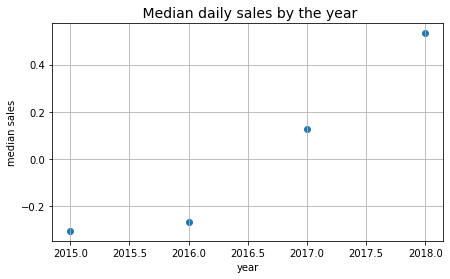

In [ ]:
x = range(7)
plt.figure(figsize=(7, 4))
plt.grid()
plt.scatter(year_medians.index, year_medians.median(axis=1))
plt.title(' Median daily sales by the year', size=14)
plt.xlabel('year')
plt.ylabel('median sales')
plt.show()

__Conclusion:__ From 2015 to 2018 median daily sales increased exponentaly

#### 3.5 Median daily sales by month

In [ ]:
def plot_median_sales_by_month(product):  
  plt.figure(figsize=(12, 3))
  plt.grid()  
  x = resampled_data.index - pd.to_timedelta(30, 'D')
  plt.scatter(x, resampled_data[product])
  plt.title(f'Median daily sales by month: product {product}')
  plt.xlabel('time')
  plt.ylabel('sales')
  plt.show;

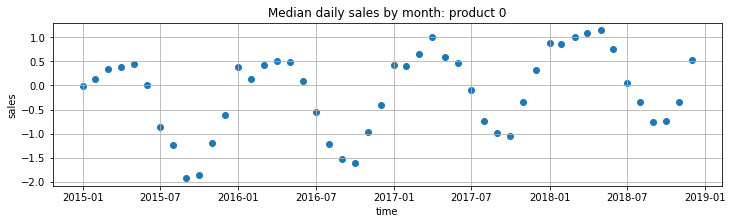

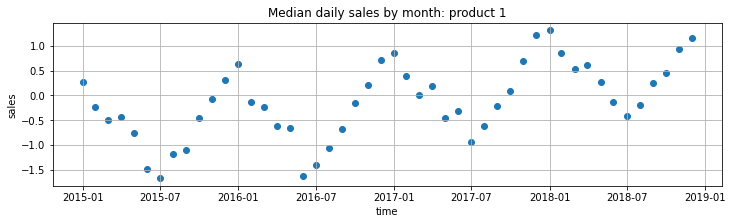

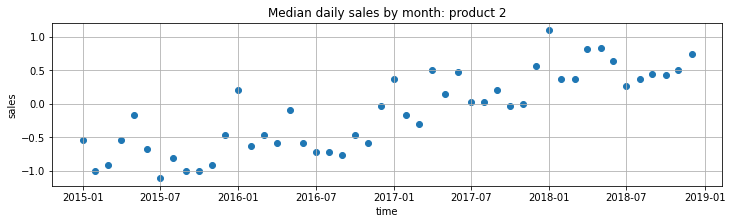

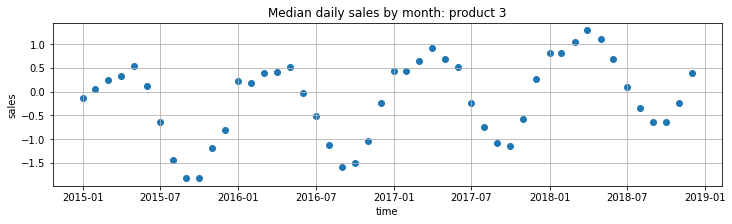

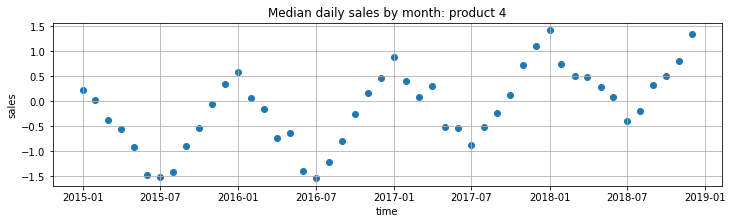

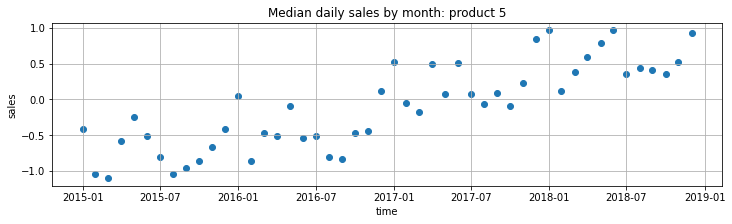

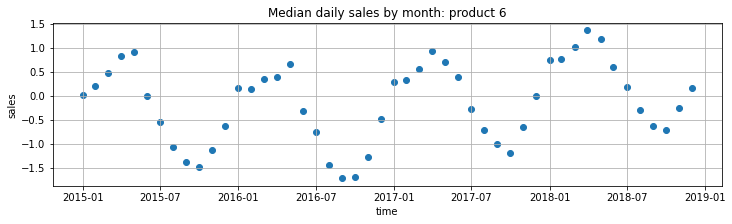

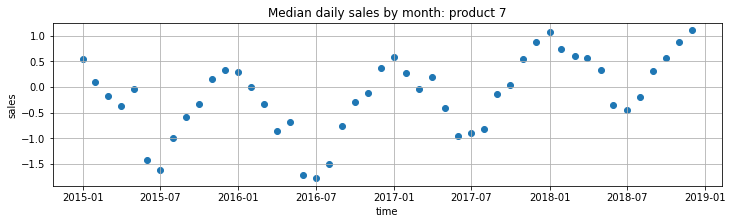

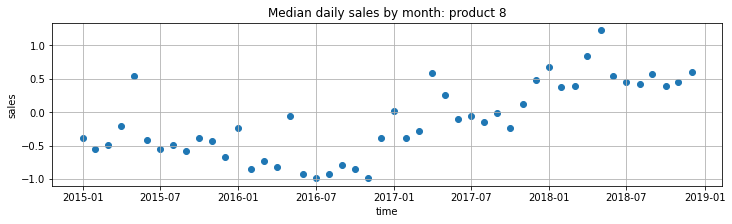

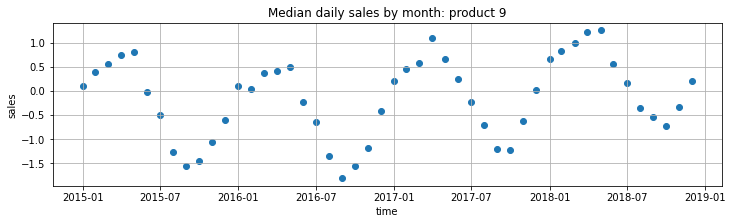

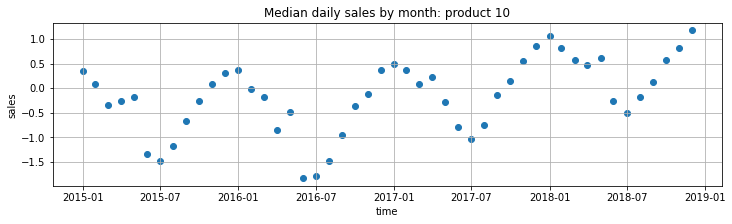

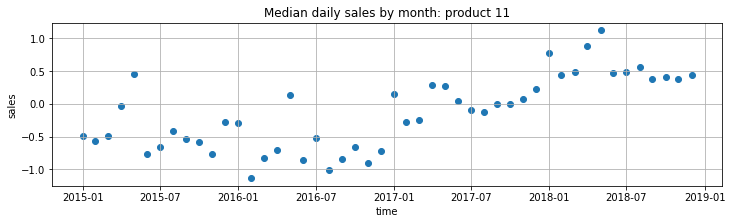

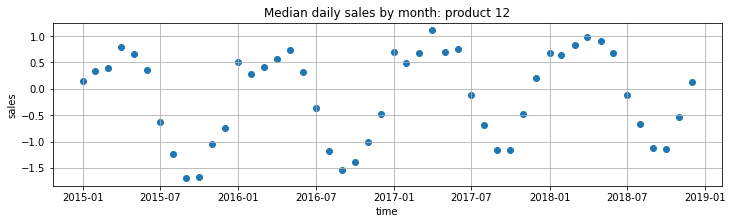

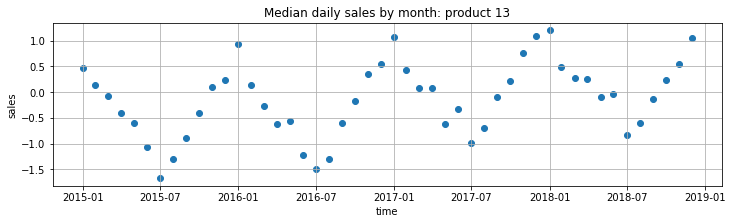

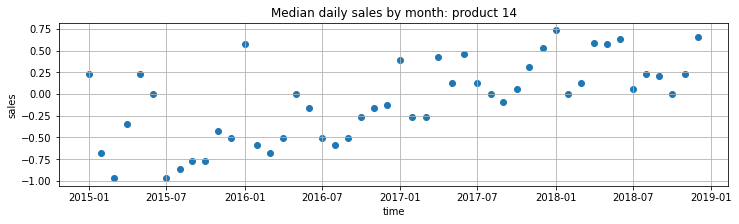

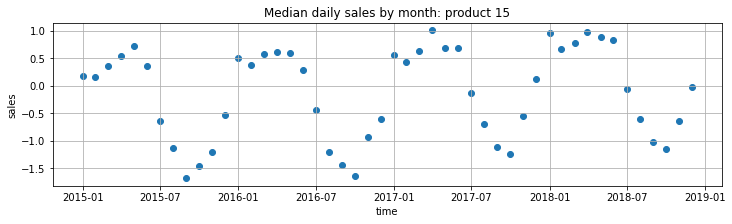

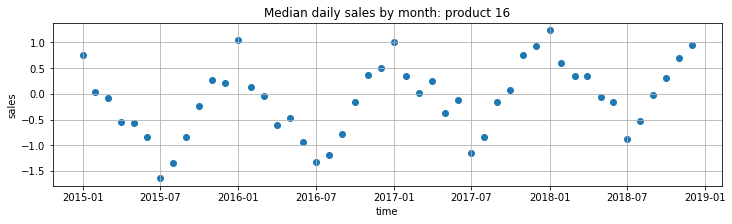

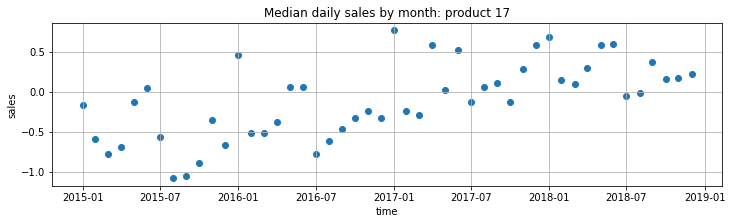

In [ ]:
resampled_data = df.resample('M').median()
for product in range(n_products):
  plot_median_sales_by_month(product)

In [ ]:
data = df.astype('float32')
month_medians = pd.pivot_table(data, index=data.index.month, aggfunc=np.median)

month_medians

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
date,,,,,,,,,,,,,,,,,,
1,0.469839,0.832889,0.345592,0.458200,0.802377,0.253097,0.358619,0.699020,0.231912,0.402649,0.748435,0.172524,0.483776,0.953212,0.457747,0.556545,0.986574,0.451850
2,0.415387,0.361388,-0.235114,0.432106,0.385271,-0.214116,0.450256,0.456056,-0.239038,0.486240,0.379423,-0.270208,0.440823,0.338111,-0.341641,0.416110,0.288576,-0.204667
3,0.657972,0.005366,-0.131319,0.689640,0.109224,-0.099642,0.733669,0.180424,-0.103414,0.709917,0.225535,-0.000871,0.671359,0.072602,-0.267199,0.640920,0.102152,-0.266724
4,0.844880,0.081686,0.209086,0.869541,-0.021920,0.268397,0.935252,-0.033402,0.249743,0.934317,0.022244,0.263039,0.815134,-0.049800,0.121200,0.817793,-0.173491,0.157211
5,0.689405,-0.315459,0.209086,0.759616,-0.436266,0.222240,0.861734,-0.083868,0.494833,0.815751,-0.139884,0.484022,0.744412,-0.377584,0.232575,0.761823,-0.352407,0.266663
6,0.369835,-0.552626,0.264945,0.370000,-0.606934,0.237541,0.253476,-1.045777,-0.102851,0.264499,-0.965433,-0.082187,0.567306,-0.627038,0.361507,0.527700,-0.538058,0.383161
7,-0.257367,-0.946940,-0.032190,-0.269319,-0.921656,0.042776,-0.349370,-0.914831,-0.017790,-0.222470,-1.049968,-0.082187,-0.269427,-1.211335,-0.127409,-0.323951,-1.171011,-0.309327
8,-0.774801,-0.636986,-0.131319,-0.781223,-0.636661,-0.099642,-0.714610,-0.766599,-0.147046,-0.714116,-0.743927,-0.106149,-0.855024,-0.814785,-0.195860,-0.851212,-0.894303,-0.287755
9,-1.082894,-0.330475,-0.000587,-1.097026,-0.338011,-0.099642,-1.108558,-0.251349,-0.081317,-1.208122,-0.314373,-0.046950,-1.283732,-0.333773,-0.267199,-1.315977,-0.326961,-0.225180


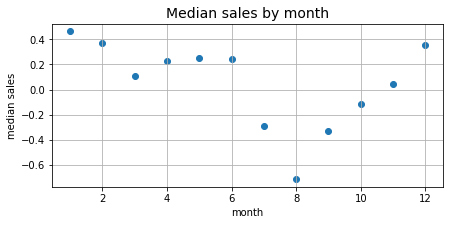

In [ ]:
x = range(1, 13)
plt.figure(figsize=(7, 3))
plt.grid()
plt.scatter(x, month_medians.median(axis=1))
plt.title('Median sales by month', size=14)
plt.xlabel('month')
plt.ylabel('median sales')
plt.show()

#### 3.6 Median daily sales by week

In [ ]:
def plot_median_sales_by_week(product):  
  plt.figure(figsize=(12, 3))
  plt.grid()  
  x = resampled_data.index - pd.to_timedelta(7, 'W')
  plt.scatter(x, resampled_data[product])
  plt.title(f'Median daily sales by week: product {product}')
  plt.xlabel('time')
  plt.ylabel('sales')
  plt.show;

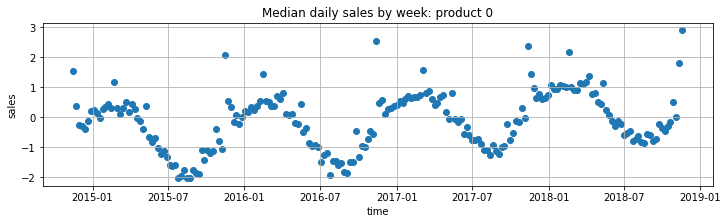

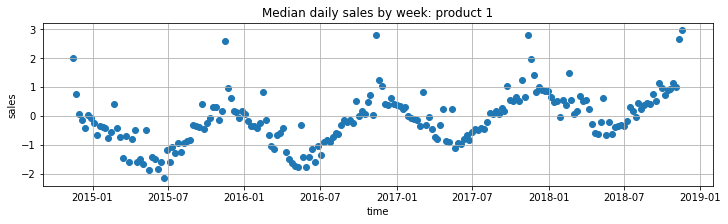

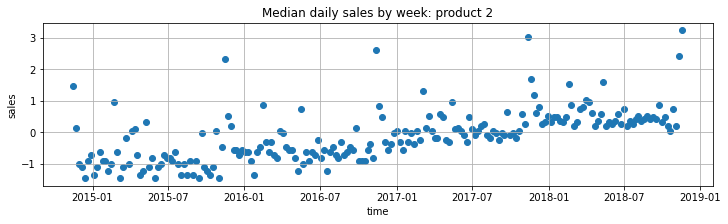

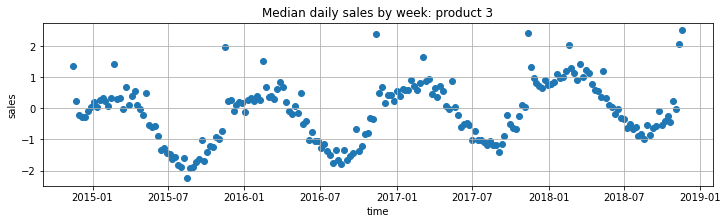

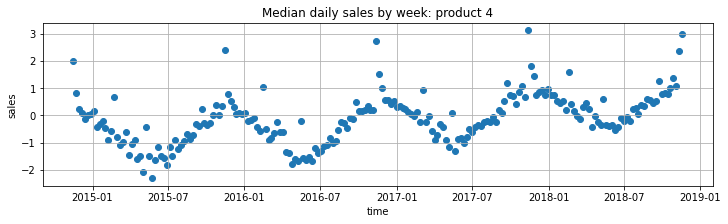

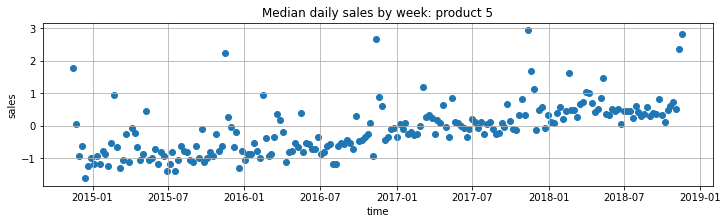

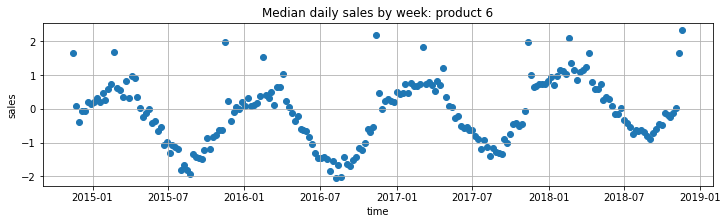

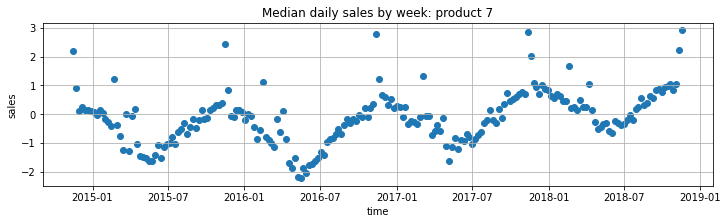

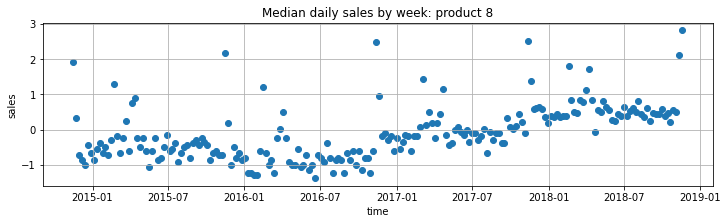

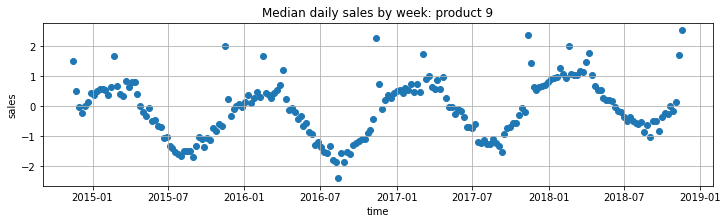

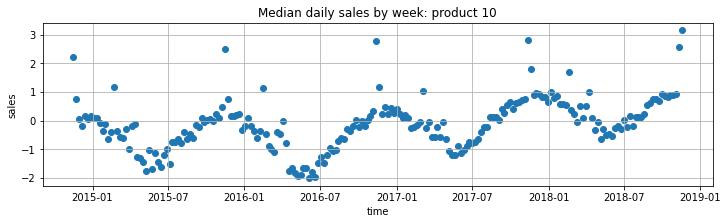

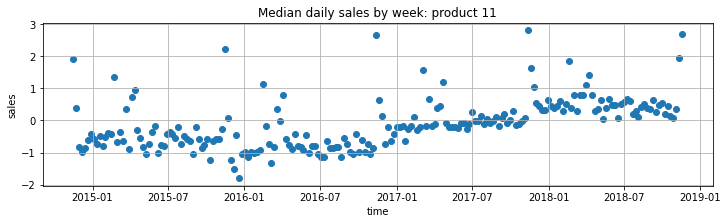

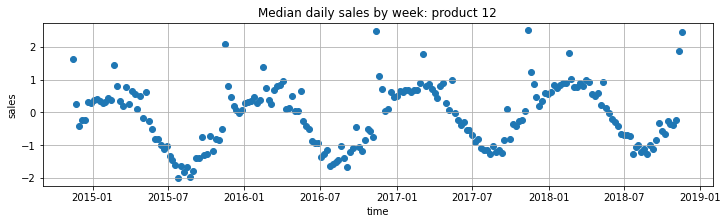

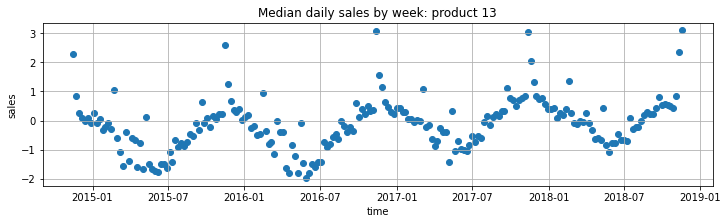

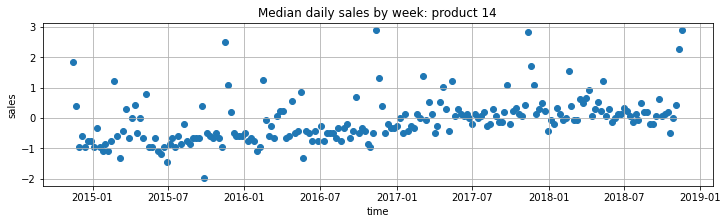

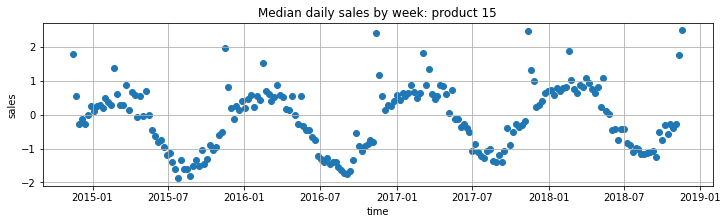

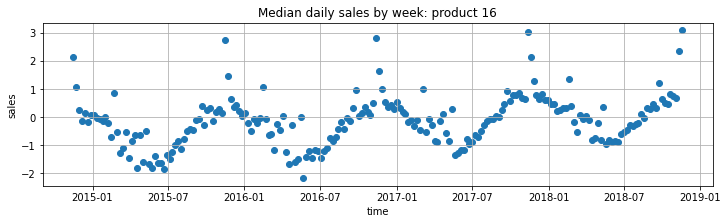

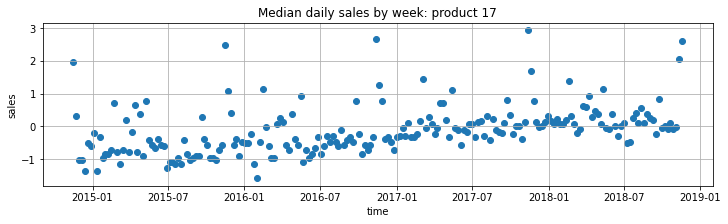

In [ ]:
resampled_data = df.resample('W').median()
for product in range(n_products):
  plot_median_sales_by_week(product)

#### 3.7 Median daily sales by the day of the week

In [ ]:
weekday_medians = pd.pivot_table(
    df, index=df.index.weekday, aggfunc=np.median)

weekday_medians

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
date,,,,,,,,,,,,,,,,,,
0,-0.211221,-0.360909,-0.461229,-0.159189,-0.277678,-0.422136,-0.228888,-0.297473,-0.439185,-0.224735,-0.314348,-0.436331,-0.210396,-0.348247,-0.500773,-0.220344,-0.277258,-0.467325
1,-0.257367,-0.285626,-0.461229,-0.111381,-0.260749,-0.378627,-0.188797,-0.297473,-0.520745,-0.267054,-0.270874,-0.495318,-0.233851,-0.319300,-0.500773,-0.227358,-0.277258,-0.515310
2,-0.204792,-0.360909,-0.461229,-0.200386,-0.382122,-0.400381,-0.265596,-0.373174,-0.386956,-0.213138,-0.276250,-0.556314,-0.210427,-0.234727,-0.500773,-0.295855,-0.326961,-0.443978
3,-0.198222,-0.330475,-0.382990,-0.219338,-0.294740,-0.422136,-0.311281,-0.335031,-0.493001,-0.206191,-0.292500,-0.465582,-0.210396,-0.290735,-0.419416,-0.121311,-0.360754,-0.467325
4,0.024371,-0.020705,-0.032190,-0.021968,-0.129961,-0.063000,0.008886,-0.100878,-0.147046,0.013038,-0.025655,-0.070286,0.042526,-0.075212,-0.061651,0.022538,-0.030793,-0.087379
5,0.689422,0.718582,0.790152,0.681742,0.742313,0.860881,0.672200,0.818611,0.907200,0.603373,0.797893,0.822646,0.717780,0.808394,0.953309,0.675164,0.850157,0.951861
6,0.716048,0.754493,0.790152,0.676462,0.732113,0.860881,0.633944,0.796382,0.859618,0.622288,0.804391,0.865150,0.725423,0.743596,0.953309,0.746514,0.749483,0.951861


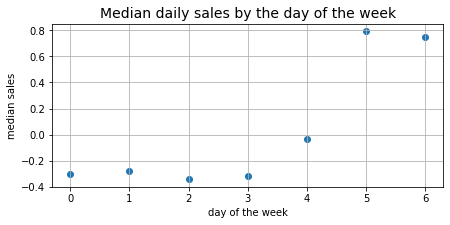

In [ ]:
x = range(7)
plt.figure(figsize=(7, 3))
plt.grid()
plt.scatter(weekday_medians.index, weekday_medians.median(axis=1))
plt.title('Median daily sales by the day of the week', size=14)
plt.xlabel('day of the week')
plt.ylabel('median sales')
plt.show()

__Conclusion:__ Sales are affected by seasonality factor - day of the week. 
They are relatively low on weekdays with a slight increase on Fridays and reach a high level on weekends.

### 4. Feature engineering

#### 4.1 Cross validation split

In [ ]:
def get_cv_index(N_FOLDS):  
  n_valid = int((n_train - WINDOW)/ (N_FOLDS + 1))
  n = int((n_train - WINDOW) % (N_FOLDS + 1))
  cv_index = {}
  for i in range(N_FOLDS):
    train_start = n 
    train_end = train_start + n_valid * (i + 1)
    valid_end = train_end + n_valid
    cv_index[i] = (train_start, train_end, valid_end)

  return cv_index  

In [ ]:
N_FOLDS = 5
cv_index = get_cv_index(N_FOLDS)
cv_index

{0: (0, 61, 122),
 1: (0, 122, 183),
 2: (0, 183, 244),
 3: (0, 244, 305),
 4: (0, 305, 366)}

#### 4.2 Generation of train, valid, test datasets

In [ ]:
def get_train_val_test_datasets(i=0):
  t0, t1, t2 = cv_index[i]

  df = table['num_sold'].iloc[:, :n_train].transpose()
  num_train, time_stamp_train = df[t0:t1+WINDOW], df[t0:t1+WINDOW].index
  num_valid, time_stamp_valid = df[t1:t2+WINDOW], df[t1:t2+WINDOW].index
  num_test, time_stamp_test = df[-SEQ_IN-1:], df[-SEQ_IN-1:].index

  scaler = JohnsonSU()
  scaler.fit(num_train)
  num_train_transformed = scaler.transform(num_train)
  num_valid_transformed = scaler.transform(num_valid)
  num_test_transformed = scaler.transform(num_test)

  datasets = {}
  datasets['train'] = (num_train_transformed, time_stamp_train)
  datasets['valid'] = (num_valid_transformed, time_stamp_valid)
  datasets['test'] = (num_test_transformed, time_stamp_test)

  return datasets, scaler

#### 4.3 Feature generation

In [ ]:
def get_num_features(df):
  num_dict = {}
  num_dict['num_sold'] = df[1:, :]  
  num_dict['1st_diff'] = df[1:, :] - df[:-1, :]
  num_dict['1st_diff_ratio'] = num_dict['1st_diff'] / df[:-1, :] 
  
  return num_dict


def preprocess_num_features(df):
  num_dict = get_num_features(df)  
  inputs = {}
  preprocessed_inputs = []
  for name, column in num_dict.items():    
    input = tf.keras.Input(shape=((n_products, 1)), name=name, dtype=tf.float32)
    inputs[name] = input
    preprocessed_inputs.append(input)

  preprocessed_inputs = layers.Concatenate(axis=-1)(preprocessed_inputs)
  num_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)

  return num_preprocessing 

In [ ]:
def get_time_features(time_stamp):
  time_stamp = time_stamp[1:]
  timestamp_s = time_stamp.map(pd.Timestamp.timestamp)
  day = 24 * 60 * 60
  week = 7 * day
  year = (365.2425) * day  
  month = year / 12
  
  time_dict = {}
  time_dict['year_sin'] = tf.sin(timestamp_s * (2 * np.pi / year))
  time_dict['year_cos'] = tf.cos(timestamp_s * (2 * np.pi / year))
  time_dict['month_sin'] = tf.sin(timestamp_s * (2 * np.pi / month))
  time_dict['month_cos'] = tf.cos(timestamp_s * (2 * np.pi / month))
  time_dict['week_sin'] = tf.sin(timestamp_s * (2 * np.pi / week))
  time_dict['week_cos'] = tf.cos(timestamp_s * (2 * np.pi / week))  

  return time_dict

def preprocess_time_features(time_stamp):
  time_dict = get_time_features(time_stamp)
  inputs = {}    
  preprocessed_inputs = []
  for name, column in time_dict.items():    
    input = tf.keras.Input(shape=(1,), name=name, dtype=tf.float32)
    inputs[name] = input
    preprocessed_inputs.append(input)

  x = layers.Concatenate()(preprocessed_inputs)
  preprocessed_inputs = layers.RepeatVector(n_products)(x)
  
  time_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)

  return time_preprocessing

In [ ]:
def preprocess_categories(time_stamp, category_features):
  inputs = {}
  preprocessed_inputs = []
  for name in category_features:    
    input = tf.keras.Input(shape=(1,), name=name, dtype=tf.string)
    inputs[name] = input
  
    string_lookup = layers.StringLookup(vocabulary=np.unique(table[name]), output_mode='one_hot')
    x = string_lookup(input)  
    x = layers.RepeatVector(len(time_stamp) - 1)(x)  
    preprocessed_inputs.append(x)

  preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
  category_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

  return category_preprocessing

In [ ]:
def feature_generation(category_features, i=0):  
  datasets, scaler = get_train_val_test_datasets(i)

  ds = {}
  for key in datasets.keys():
    num_ds, time_stamp = datasets[key]
    num_dict = get_num_features(num_ds)
    num_preprocessing = preprocess_num_features(num_ds)
    preprocessed_num = num_preprocessing(num_dict)

    time_dict = get_time_features(time_stamp)
    time_preprocessing = preprocess_time_features(time_stamp)
    preprocessed_time = time_preprocessing(time_dict)
    
    category_features_dict = {name: table[name].iloc[:, 0].values for name in category_features}
    category_preprocessing = preprocess_categories(time_stamp, category_features)
    preprocessed_categories = tf.transpose(category_preprocessing(category_features_dict), [1, 0, 2])

    ds[key] = tf.concat([preprocessed_num, preprocessed_time, preprocessed_categories], axis=-1)

  return ds, scaler

In [ ]:
def split_window(dataset):
  features, targets = [], []
  for w in dataset:
    features.append(w[:SEQ_IN, :, :])
    targets.append(w[SEQ_IN:, :, :])

  features = tf.stack(features)
  targets = tf.stack(targets)

  return features, targets


def prepare_dataset(dataset):
  features, targets = split_window(dataset)

  perm = [0, 2, 1, 3]
  features = tf.transpose(features, perm),
  targets = tf.transpose(targets, perm)

  n = 20
  features = tf.reshape(features, [-1, SEQ_IN, n])
  targets = tf.reshape(targets, [-1, SEQ_OUT, n])

  return features, targets


def get_X_y(category_features, i, window_size):
  ds, scaler = feature_generation(category_features, i)
  X_y = {}
  for key in ds.keys():    
    dataset = tf.data.Dataset.from_tensor_slices(ds[key])
    if key == 'test':
      tensor = tf.stack([w for w in dataset])
      X_y[key] = tf.transpose(tensor, [1, 0, 2])      
      continue
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.shuffle(buffer_size=300, seed=25)
    dataset = dataset.cache()

    X_y[key] = prepare_dataset(dataset)

  return X_y, scaler

### 5. Model

#### 5.1 Transformer

https://keras.io/examples/nlp/text_classification_with_transformer/

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

#### 5.2 Time2Vec

https://arxiv.org/abs/1907.05321

In [ ]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

#### 5.3 Model parameters

* N_HEADS: The number of transformer heads in the model.
* FF_DIM: The dimension of the feed-forward networks used in the model.
* N_BLOCKS: Number of transformer blocks to use in the model. (Depth)
* EMBED_DIM: Embedding dim for the transformer to embed the input sequence into.
* DROPUT_RATE: Droput rate to use in the transformer blocks.
* TIME_2_VEC_DIM: Time2Vec embedding dimension.
* SKIP_CONNECTION_STRENGTH: A constant to muliply the skip connections by: ((1.0 - SKIP_CONNECTION_STRENGTH) x) + (SKIP_CONNECTION_STRENGTH x_old)

In [ ]:
N_HEADS = 8
FF_DIM = 256
N_BLOCKS = 6
EMBED_DIM = 64

DROPOUT_RATE = 0.0
TIME_2_VEC_DIM = 3
SKIP_CONNECTION_STRENGTH = 0.9

#### 5.4 Final model

In [ ]:
def get_model(input_shape, time2vec_dim=3):
  # encoder 
  encoder_inputs = layers.Input(input_shape) 
  x = encoder_inputs
  time_embedding = layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
  x = layers.Concatenate(axis=-1)([x, time_embedding])
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  new_dim = x.shape[-1]
  for k in range(N_BLOCKS):
    x_old = x
    transformer_block_1 = TransformerBlock(EMBED_DIM, new_dim, N_HEADS, FF_DIM, DROPOUT_RATE)
    x = transformer_block_1(x)
    x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)
  
  encoder_outputs = layers.Flatten()(x)

  x = layers.Dense(SEQ_OUT, activation='linear')(encoder_outputs)
  x = layers.Reshape((SEQ_OUT, 1))(x)  
  
  decoder_outputs = x  
    
  model = Model(encoder_inputs, decoder_outputs)
  model.compile(tf.keras.optimizers.Adam(0.001), tf.keras.losses.Huber(), metrics = [smape])

  return model

### 6. Traning

In [ ]:
TRAIN_MODEL = True
EPOCHS = 3
BATCH_SIZE = n_products
N_FOLDS = 5

In [ ]:
def smape(y_true, y_pred):
    y_true, y_pred = tf.cast(y_true, tf.float64), tf.cast(y_pred, tf.float64)
    return 1 / len(y_true) * tf.reduce_sum(2 * tf.abs(y_pred - y_true) / (tf.abs(y_true) + tf.abs(y_pred)) * 100)

In [ ]:
#!rm -r '/content/models'
!mkdir '/content/models'

In [ ]:
cv_index = get_cv_index(N_FOLDS)

all_test_preds = []
for fold_idx in range(4, N_FOLDS):
  print(f'------ fold {fold_idx} ------')
  X_y, scaler = get_X_y(category_features, fold_idx, WINDOW)
  x_train, y_train = X_y['train']  
  x_valid, y_valid = X_y['valid']
  x_test = X_y['test']

  y_train = y_train[:, :, 0]
  y_valid = y_valid[:, :, 0]
  
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_smape', patience=10, verbose=0, mode='min', restore_best_weights=True)

  model = get_model(x_train.shape[1:], TIME_2_VEC_DIM)
  if TRAIN_MODEL:    
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
              validation_data=(x_valid, y_valid), callbacks=[early_stop])
    model.save_weights(f'/content/models/m_{fold_idx}.h5')
  else:
    model.load_weights(f'/content/models/m_{fold_idx}.h5')


  preds = model.predict(x_test)
  preds = tf.transpose(preds[:,:,0], [1, 0])

  preds = scaler.inv_transform(preds)
  print(preds[:3, :5])

  all_test_preds.append(preds)

------ fold 4 ------
Epoch 1/3
305/305 [==============================] - 246s 793ms/step - loss: 0.6566 - smape: 39736.8984 - val_loss: 0.2596 - val_smape: 34573.8203
Epoch 2/3
305/305 [==============================] - 239s 783ms/step - loss: 0.1094 - smape: 27048.3086 - val_loss: 0.1531 - val_smape: 29435.1816
Epoch 3/3
305/305 [==============================] - 239s 784ms/step - loss: 0.0523 - smape: 21761.0859 - val_loss: 0.1232 - val_smape: 27257.2344
tf.Tensor(
[[392.485 250.438 111.373 699.154 439.886]
 [406.143 262.732 117.593 698.775 414.79 ]
 [379.    244.059 105.968 695.274 422.208]], shape=(3, 5), dtype=float32)


### 7. Predictions

In [ ]:
preds = np.median(all_test_preds, axis = 0).astype(int)
preds[:4, :5]

array([[392, 250, 111, 699, 439],
       [406, 262, 117, 698, 414],
       [379, 244, 105, 695, 422],
       [387, 226, 106, 703, 418]])

### 8. Submitting to Kaggle

In [ ]:
for idx in range(n_products):
  (i, j, k) = ind[idx]
  test.loc[(test['country'] == i) & (test['store'] == j) & (test['product'] == k), 'num_sold'] = preds[:, idx]

In [ ]:
sub = pd.read_csv('/content/input/sample_submission.csv')
sub['num_sold'] = test['num_sold'].astype(int).values
sub.to_csv('submission.csv', index = False)
sub

,row_id,num_sold
0,26298,250
1,26299,392
2,26300,111
3,26301,439
4,26302,699
...,...,...
6565,32863,476
6566,32864,147
6567,32865,534
6568,32866,851
